<a href="https://colab.research.google.com/github/oreilly-japan/ml-at-work/blob/master/chap07/all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-947-2.gif)

이 노트북은 한빛미디어에서 발생한 [<<머신러닝 실무 프로젝트 2판>>]()의 샘플 코드입니다. 코드 설명은 책 내용을 확인합니다. 또한, 이 코드를 실행한 결과에 대해 한빛미디어 및 옮긴이는 일체의 책임을 지지 않습니다.

# 7장 효과 검증: 머신러닝 기반 정책 성과를 판단한다

Author: hagino3000  
Date: 2021-03-21

In [1]:
# 나눔 폰트 설치. 설치후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,487 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.tools.print_version
plt.rc('font', family='NanumBarunGothic') 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(statsmodels.tools.print_version.show_versions())


INSTALLED VERSIONS
------------------
Python: 3.7.11.final.0
OS: Linux 5.4.104+ #1 SMP Sat Jun 5 09:50:34 PDT 2021 x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8

Statsmodels

Installed: 0.10.2 (/usr/local/lib/python3.7/dist-packages/statsmodels)

Required Dependencies

cython: 0.29.23 (/usr/local/lib/python3.7/dist-packages/Cython)
numpy: 1.19.5 (/usr/local/lib/python3.7/dist-packages/numpy)
scipy: 1.4.1 (/usr/local/lib/python3.7/dist-packages/scipy)
pandas: 1.1.5 (/usr/local/lib/python3.7/dist-packages/pandas)
    dateutil: 2.8.1 (/usr/local/lib/python3.7/dist-packages/dateutil)
patsy: 0.5.1 (/usr/local/lib/python3.7/dist-packages/patsy)

Optional Dependencies

matplotlib: 3.2.2 (/usr/local/lib/python3.7/dist-packages/matplotlib)
    backend: module://ipykernel.pylab.backend_inline 
cvxopt: 1.2.6 (/usr/local/lib/python3.7/dist-packages/cvxopt)
joblib: 1.0.1 (/usr/local/lib/python3.7/dist-packages/joblib)

Developer Tools

IPython: 5.5.0 (/usr/local/lib/python3.7/dist-packag

## 인과 효과 추정

In [5]:
import datetime as dt

x = pd.date_range(dt.datetime(2017, 3, 1), dt.datetime(2017, 4, 1))
y = np.random.randn(len(x)) * 20 + 1000
y2 = np.random.randn(len(x)) * 20 + 1000

y_change = list(np.zeros(int(len(x)/2))) + list(np.ones(int(len(x)/2)) + 200)
y_change2 = list(np.zeros(int(len(x)/2))) + list(np.ones(int(len(x)/2)).cumsum() * 7)

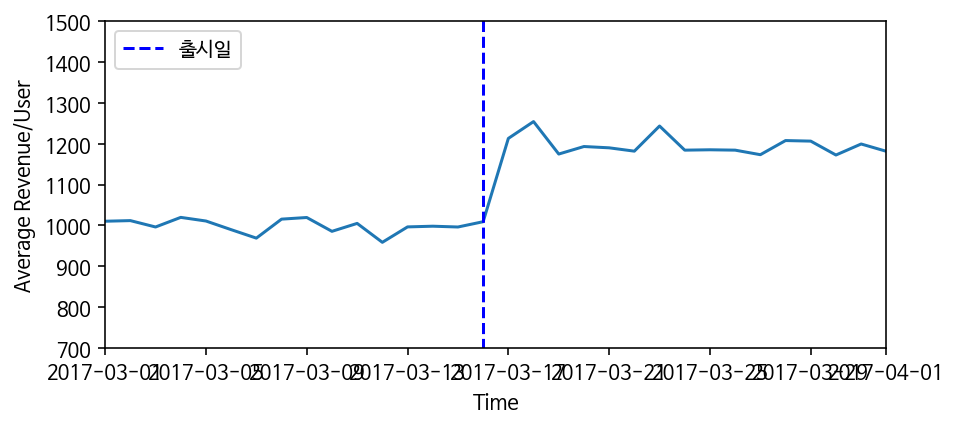

In [6]:
plt.figure(figsize=(7, 3))
plt.plot(x, y + y_change)
plt.ylim(700, 1500)
plt.xlabel('Time')
plt.xlim(x[0], x[-1])
plt.ylabel('Average Revenue/User')
plt.plot([dt.datetime(2017,3,16), dt.datetime(2017,3,16)], [0, 2000], 'b--', label='출시일')
plt.legend(loc='upper left')

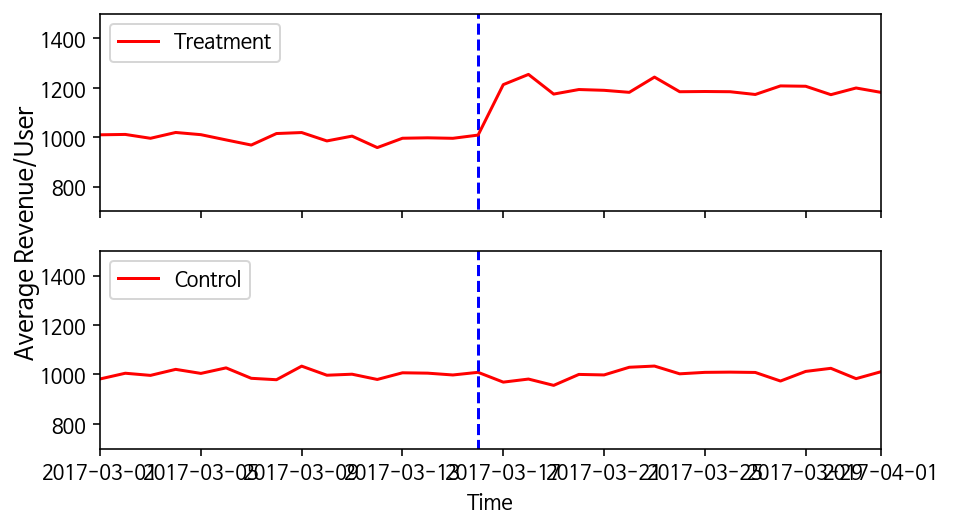

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 4))
ax1.plot([dt.datetime(2017,3,16), dt.datetime(2017,3,16)], [0, 2000], 'b--')
ax1.plot(x, y + y_change, 'r-', label='Treatment')
ax1.set_ylim(700, 1500)
ax2.plot(x, y2, 'r-', label='Control')
ax1.legend(loc='upper left')
ax2.plot([dt.datetime(2017,3,16), dt.datetime(2017,3,16)], [0, 2000], 'b--')
ax2.set_ylim(700, 1500)
plt.xlabel('Time')
ax1.set_xlim(x[0], x[-1])
ax2.set_xlim(x[0], x[-1])
fig.text(0.04, 0.5, 'Average Revenue/User', va='center', rotation='vertical', fontsize=12)
plt.legend(loc='upper left')

## 가설 검정 프레임

### 동전이 비뚤어지지는 않았은가?

In [8]:
x = np.arange(0, 21)
y = scipy.stats.binom.pmf(x, 20, 0.5)

Text(0, 0.5, '확률')

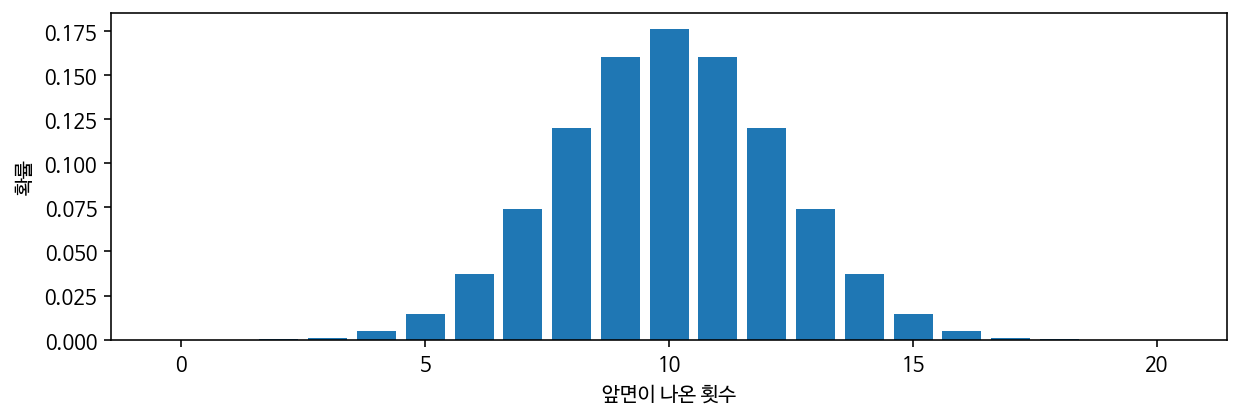

In [9]:
plt.figure(figsize=(10, 3))
plt.bar(x, y)
plt.xlabel('앞면이_나온_횟수')
plt.ylabel('확률')

In [13]:
import pandas as pd
p_value = pd.DataFrame({'앞면이_나온_횟수':x, '확률': y}).query(
    '앞면이_나온_횟수 >= 15'
    )['확률'].sum()
print(p_value)

0.02069473266601554


In [15]:
import pandas as pd
p_value = pd.DataFrame({'앞면이_나온_횟수':x, '확률': y}).query(
    '앞면이_나온_횟수 >= 15'
    )['확률'].sum()
print('{:,.4f}'.format(p_value))

0.0207


### 획득한 사용자의 지속 이용률 비교

In [16]:
# 테스트 데이터, 지속 이용 사용자 수, 이탈 사용자 수
a = {'n_success': 40, 'n_observation': 205, 'p': 40/205}
b = {'n_success': 62, 'n_observation': 290, 'p': 62/290}
   
print(f'Sample A: size={a["n_observation"]}, converted={a["n_success"]}, mean={a["p"]:.3f}')
print(f'Sample B: size={b["n_observation"]}, converted={b["n_success"]}, mean={b["p"]:.3f}')

Sample A: size=205, converted=40, mean=0.195
Sample B: size=290, converted=62, mean=0.214


In [17]:
x = np.linspace(0, 1, 200)

def calc_err(data):
    p = data['p']
    n = data['n_observation']
    return np.sqrt(p*(1-p)/n)

# 유입 경로가 A인 표본
y_a = scipy.stats.norm.pdf(x, a['p'], calc_err(a))

# 유입 경로가 B인 표본
y_b = scipy.stats.norm.pdf(x, b['p'], calc_err(b))

Text(0, 0.5, '가능도')

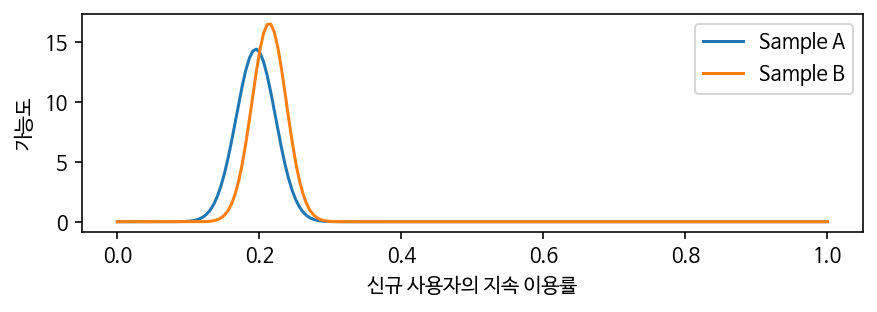

In [18]:
 plt.figure(figsize=(7, 2))
 plt.plot(x, y_a, label='Sample A')
 plt.plot(x, y_b, label='Sample B')
 plt.legend(loc='best')
 plt.xlabel('신규 사용자의 지속 이용률')
 plt.ylabel('가능도')

Text(0, 0.5, '가능도')

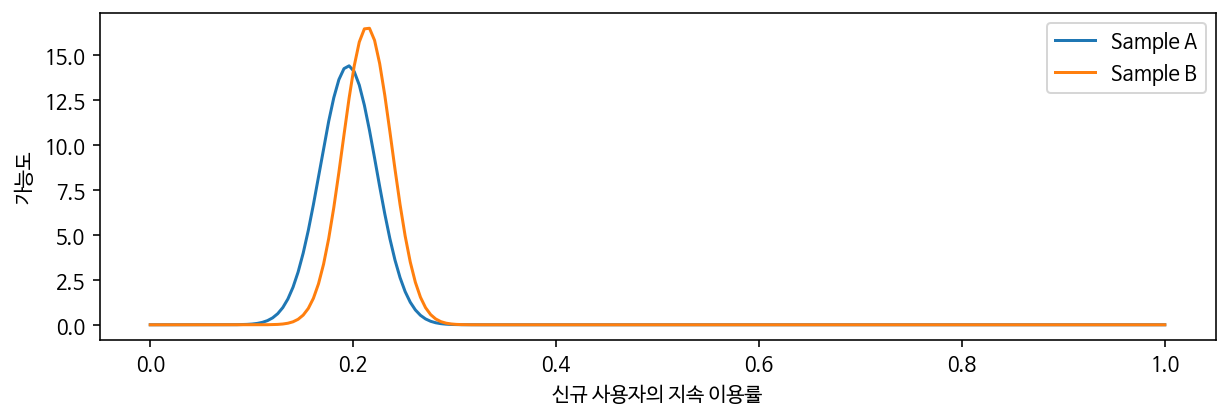

In [19]:
plt.figure(figsize=(10, 3))
plt.plot(x, y_a, label='Sample A')
plt.plot(x, y_b, label='Sample B')
plt.legend(loc='best')
plt.xlabel('신규 사용자의 지속 이용률')
plt.ylabel('가능도')

In [20]:
print(scipy.stats.chi2_contingency.__doc__)

Chi-square test of independence of variables in a contingency table.

    This function computes the chi-square statistic and p-value for the
    hypothesis test of independence of the observed frequencies in the
    contingency table [1]_ `observed`.  The expected frequencies are computed
    based on the marginal sums under the assumption of independence; see
    `scipy.stats.contingency.expected_freq`.  The number of degrees of
    freedom is (expressed using numpy functions and attributes)::

        dof = observed.size - sum(observed.shape) + observed.ndim - 1


    Parameters
    ----------
    observed : array_like
        The contingency table. The table contains the observed frequencies
        (i.e. number of occurrences) in each category.  In the two-dimensional
        case, the table is often described as an "R x C table".
    correction : bool, optional
        If True, *and* the degrees of freedom is 1, apply Yates' correction
        for continuity.  The effect of the c

In [21]:
# 카이제곱 검정
_, p_value, _, _ = scipy.stats.chi2_contingency([
    [a['n_success'], a['n_observation'] - a['n_success']],
    [b['n_success'], b['n_observation'] - b['n_success']]
])
print(p_value)

0.694254736449269


### 차의 신뢰구간을 구한다


In [22]:
def calc_combined_err(a, b, alpha):
   p_a = a['p']
   n_a = a['n_observation']
   p_b = b['p']
   n_b = b['n_observation']
   z = scipy.stats.norm.ppf(1 - alpha/2)
   return z * np.sqrt(p_a*(1-p_a)/n_a + p_b*(1-p_b)/n_b)

def calc_diff_confidence_interval(a, b, alpha):
   err = calc_combined_err(a, b, alpha)
   diff = a['p'] - b['p']
   return (diff - err, diff + err)

calc_diff_confidence_interval(a, b, alpha=0.05)

(-0.09057004943075483, 0.05322774497322749)

### 거짓 양성과 거짓 음성

In [23]:
np.random.seed(34)

In [24]:
mu = 0.5  # 앞면이 나올 확률 50%
init_sample = list(scipy.stats.bernoulli.rvs(mu, size=20))

sample = init_sample
p_value_history = []
for i in range(200):
    # 직전 20회의 결과를 사용한 검정
    _, p_value = scipy.stats.ttest_1samp(sample[-20:], 0.5)
    p_value_history.append(p_value)
    # 새롭게 동전을 던진 결과를 저장
    sample.append(scipy.stats.bernoulli.rvs(mu))

Text(0, 0.5, 'p값')

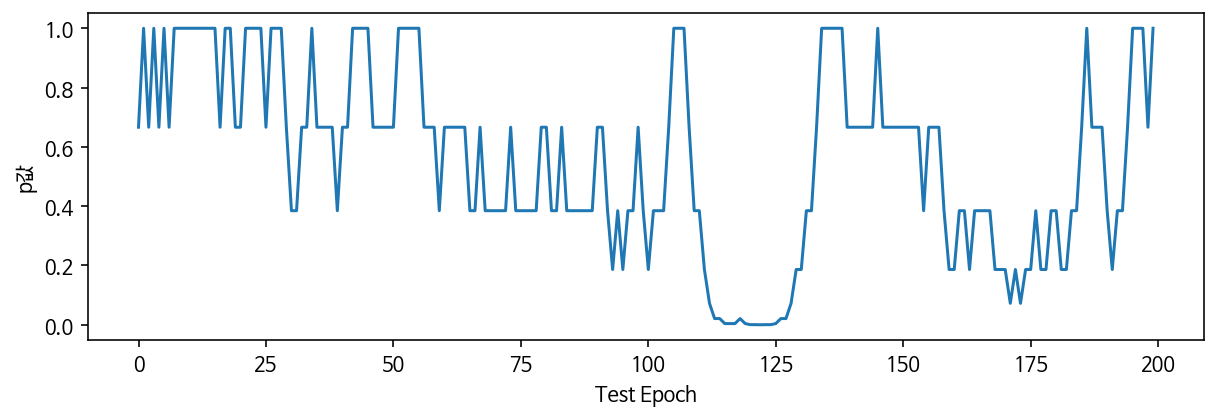

In [25]:
plt.figure(figsize=(10, 3))
plt.plot(p_value_history)
plt.xlabel('Test Epoch')
plt.ylabel('p값')

In [26]:
np.random.seed(31)
max_sample = 3000000
# 표본 A 평균: 45.1%
a = scipy.stats.bernoulli.rvs(0.451, size=max_sample)
# 표본 B 평균: 45.2%
b = scipy.stats.bernoulli.rvs(0.452, size=max_sample)
p_values = []
# 5,000씩 샘플 크기를 증가하면서 검증
sample_sizes = np.arange(1000, max_sample, 5000)
for sample_size in sample_sizes:
    _, p_value = scipy.stats.ttest_ind(a[:sample_size], b[:sample_size], equal_var=False)
    p_values.append(p_value)

Text(0, 0.5, 'p값')

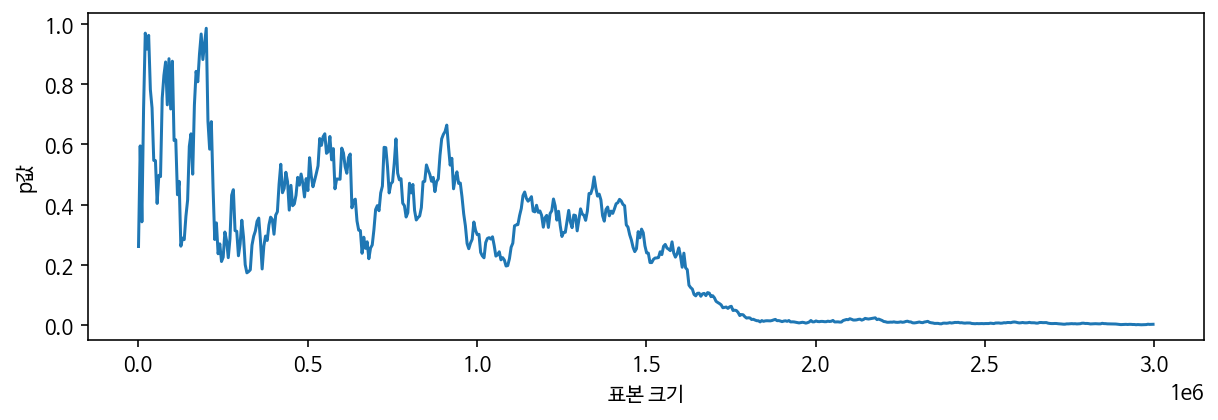

In [27]:
plt.figure(figsize=(10, 3))
plt.plot(sample_sizes, p_values)
plt.xlabel('표본 크기')
plt.ylabel('p값')

## A/B 테스트 설계 및 실시

E(Y0) = 0.05171428571428571
E(Y1) = 0.06571428571428571


(0.03, 0.08)

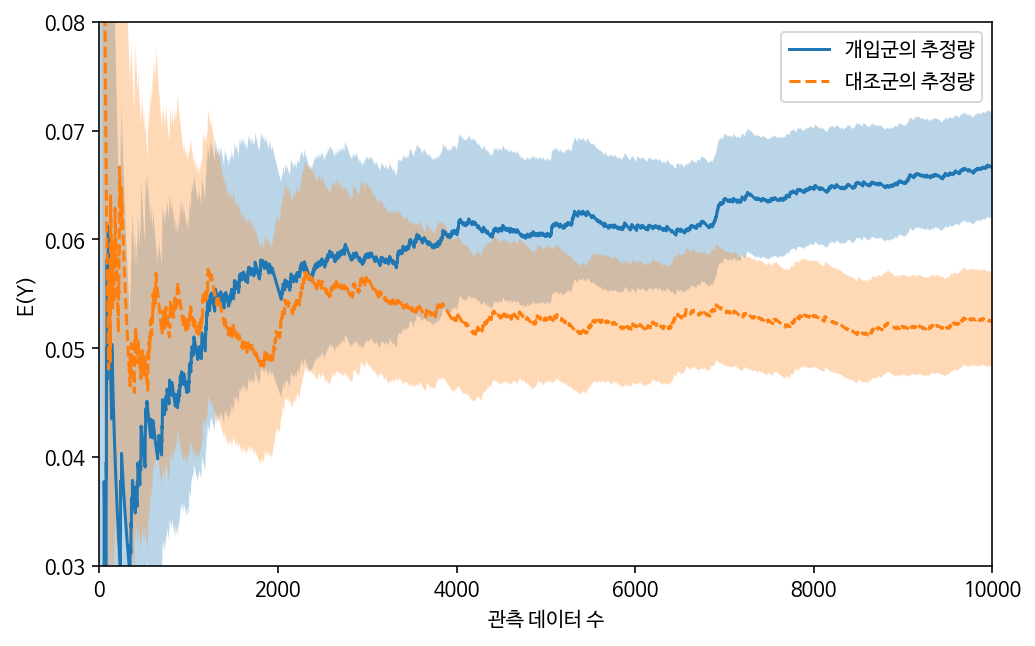

In [28]:
np.random.seed(4)
T = 14000

control = scipy.stats.binom(1, 0.05).rvs(size=T)
print('E(Y0) =', np.mean(control))
treatment = scipy.stats.binom(1, 0.065).rvs(size=T)
print('E(Y1) =', np.mean(treatment))

n_observed = np.ones(T).cumsum().astype(int)
treatment_p = treatment.cumsum()/n_observed
control_p = control.cumsum()/n_observed

import statsmodels.stats.proportion

@np.vectorize
def calc_confidence_interval(n_success, n_observed):
   return statsmodels.stats.proportion.proportion_confint(
      n_success, n_observed, alpha=0.05, method='wilson'
   )

treatment_lcb, treatment_ucb = calc_confidence_interval(treatment.cumsum(), n_observed)
control_lcb, control_ucb = calc_confidence_interval(control.cumsum(), n_observed)

fig = plt.figure(figsize=(8, 5))
plt.plot(n_observed, treatment_p, label='개입군의 추정량')
plt.fill_between(n_observed, treatment_lcb, treatment_ucb, alpha=0.3, interpolate=True)
plt.plot(n_observed, control_p, linestyle='dashed',  label='대조군의 추정량')
plt.fill_between(n_observed, control_lcb, control_ucb, alpha=0.3, interpolate=True)
plt.legend(loc='best')
plt.xlim(0, 10000)
plt.xlabel('관측 데이터 수')
plt.ylabel('E(Y)')
plt.ylim(0.030, 0.08)

(0.0, 10000.0)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


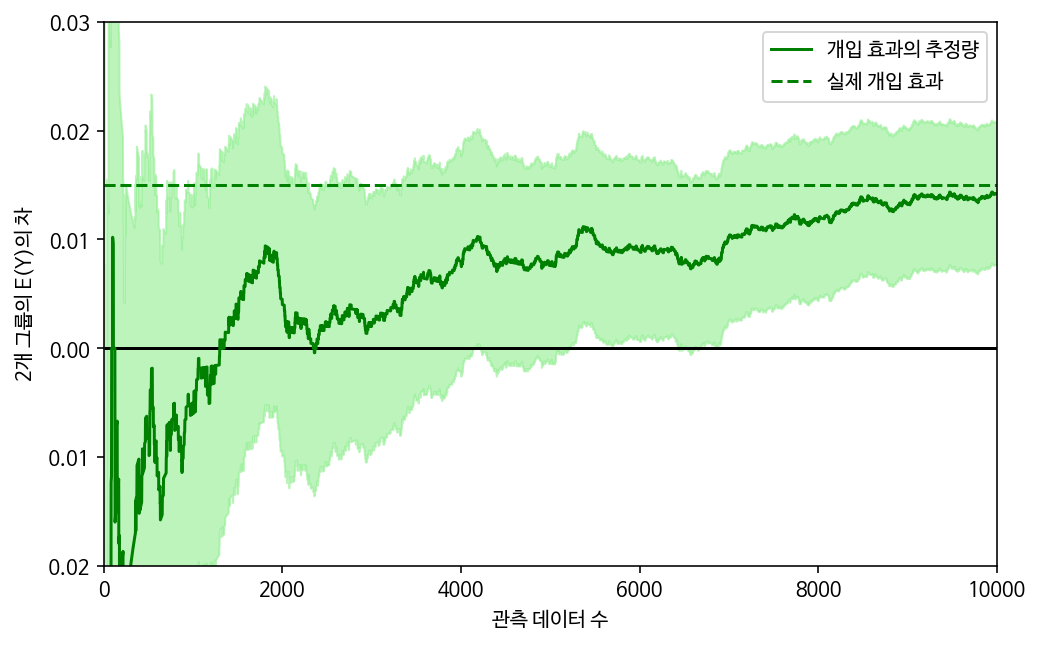

In [29]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

def _calc_diff_confidence_interval(n_success_a, n_success_b, n_observed):
   if n_observed < 10:
      return (1, -1)
   sample_a = DescrStatsW(np.append(np.ones(n_success_a), np.zeros(n_observed - n_success_a)))
   sample_b = DescrStatsW(np.append(np.ones(n_success_b), np.zeros(n_observed - n_success_b)))
   lcb, ucb = CompareMeans(sample_a, sample_b).zconfint_diff(alpha=0.05)
   return float(lcb), float(ucb)
calc_diff_confidence_interval = np.vectorize(_calc_diff_confidence_interval, otypes=[np.float, np.float])

diff_interval_lcb, diff_interval_ucb = calc_diff_confidence_interval(
   treatment.cumsum(),
   control.cumsum(),
   n_observed
)

diff = treatment_p - control_p

xmax = 10000
fig = plt.figure(figsize=(8, 5))
plt.plot(n_observed, diff, color='green', label='개입 효과의 추정량')
plt.fill_between(n_observed, diff_interval_lcb, diff_interval_ucb, alpha=0.6, color='lightgreen', interpolate=True)
plt.hlines([0], 0, xmax, "black")
plt.hlines([0.015], 0, xmax, "green", linestyles='dashed', label='실제 개입 효과')
plt.ylim(-0.02, 0.03)
plt.ylabel('2개 그룹의 E(Y)의 차')
plt.xlabel('관측 데이터 수')
plt.legend(loc='best')
plt.xlim(0, xmax)